# Testing

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

D:\dev\autocaption


In [2]:
import os
import torch
from models import Encoder, Decoder
import matplotlib.pyplot as plt
from utils import get_caption
from data import *
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from fastprogress.fastprogress import progress_bar, master_bar
from ax.service.ax_client import AxClient


# Best model after hyperparameter tuning (Tuned with BLEU)
ax_bleu = AxClient.load_from_json_file(filepath="./data/experiments/2020-06-16/ax_experiment.json")
model_name = './data/experiments/2020-06-16/ffbb4222-afc6-11ea-b217-98fa9bfd2b26/models/model-6.ckpt'
checkpoint = torch.load(model_name)


[INFO 06-17 21:03:59] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [3]:
cfg, metrics = ax_bleu.get_best_parameters()
cfg["device"] = "cuda"
display(cfg)
display(metrics)

{'lr': 0.0005577729577198625,
 'dropout': 0.31784547520801426,
 'momentum': 0.014810723778791727,
 'n_layers': 1,
 'batch_size': 32,
 'embed_size': 128,
 'hidden_size': 512,
 'num_epochs': 10,
 'device': 'cuda'}

({'perplexity': 19.3963276125, 'bleu': 0.050365224900000005},
 {'perplexity': {'perplexity': 0.0}, 'bleu': {'bleu': 0.0}})

In [4]:
loader = get_loader("TEST", cfg["batch_size"])
encoder = Encoder(cfg["embed_size"], cfg["momentum"]).to(cfg["device"])
decoder = Decoder(cfg["embed_size"], 
                  cfg["hidden_size"], 
                  len(loader.dataset.vocab),
                  cfg["n_layers"],
                  cfg["dropout"]).to(cfg["device"])

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()

Decoder(
  (embed): Embedding(1842, 128)
  (dropout): Dropout(p=0.31784547520801426, inplace=False)
  (lstm): LSTM(128, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1842, bias=True)
)

In [5]:
results = []
results_beam = []

mb = progress_bar(loader)

with torch.no_grad():
    for (orig_image, image, all_caps) in mb:
        image = image.to(cfg["device"])
            
        # Greedy
        candidates = get_caption(image, 
                                encoder, 
                                decoder, 
                                loader.dataset.vocab,
                                "greedy",
                                True)
        
        candidates_bleu = [c.split() for c in candidates][0]
        all_caps = [c[0].split() for c in all_caps]
        bleu_score = sentence_bleu(all_caps, candidates_bleu, smoothing_function=SmoothingFunction().method1)
        

        # Beam
        candidates_beam = get_caption(image, 
                                encoder, 
                                decoder, 
                                loader.dataset.vocab,
                                "beam",
                                True)

        candidates_bleu = [c.split() for c in candidates_beam][0]
        bleu_score_beam = sentence_bleu(all_caps, candidates_bleu, smoothing_function=SmoothingFunction().method1)
        
        
        # Logging
        all_caps = [" ".join(c) for c in all_caps]
        
        results.append({"orig_image": orig_image, 
                        "caption": candidates[0],
                        "all_caps": all_caps,
                        "bleu": bleu_score})
                
        results_beam.append({"orig_image": orig_image, 
                        "caption": candidates_beam,
                        "all_caps": all_caps,
                        "bleu": bleu_score_beam})
        

['the dog is swimming in the pool']


## Greedy results

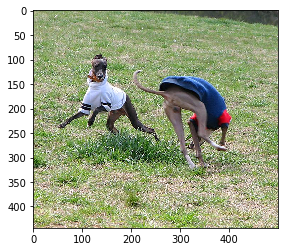

>Generated caption: 
two dogs play in the grass
>Original captions: 
the two greyhound dogs wearing sweaters are playing in the grass
two dogs play in the grass
two dogs wearing shirts play in the green grass
two dogs wearing sweaters play in field
two dogs wearing sweaters play in the grass
>BLEU4 score: 1.000


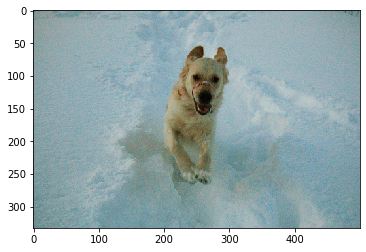

>Generated caption: 
dog running through the snow
>Original captions: 
dog is playing in the deep snow
dog running through deep snow pack
dog runs through the deep snow
white dog is running through the snow
white dog running through snow
>BLEU4 score: 0.841


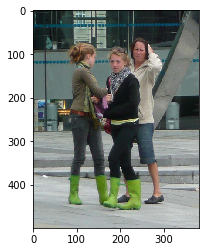

>Generated caption: 
two women walk down the street
>Original captions: 
three women standing on city street
three women walk down the street
two girls and woman walking on the sidewalk
two girls in bright green boots and woman are together
two young ladies in green boots are walking through an urban area while an older lady wearing black shoes follows them
>BLEU4 score: 0.795


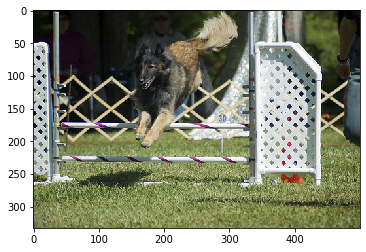

>Generated caption: 
dog jumps over hurdle
>Original captions: 
black and brown dog jumping over two white and purple stiped poles
dog jumps over hurdle in the grass
dog jumps over an obstacle
black and brown dog jumping over hurdle with white supports
dog performing during an outdoor dog show
>BLEU4 score: 0.779


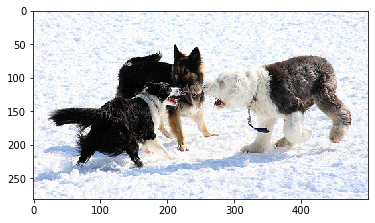

>Generated caption: 
two dogs playing in the snow
>Original captions: 
group of dogs look at each other while standing in the snow
three dogs come face to face with each other in snowy field
three dogs in the snow
three dogs meet in the snow
three dogs playing in the snow
>BLEU4 score: 0.760


In [21]:
results = sorted(results, key=lambda k: k['bleu'], reverse=True) 

top = results[0:5]
worst = results[-5:]

for e in top:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


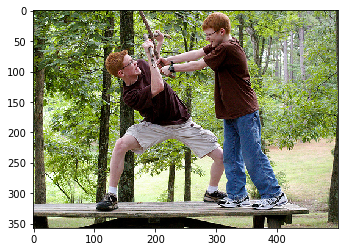

>Generated caption: 
young boy jumping off of swing set
>Original captions: 
two boys wearing brown shirts tug at rope on wooden platform
two boys with red hair and glasses stand on table and fight
two redheaded boys in brown shirts stand on table and are fighting with sticks
two redheaded boys with glasses stand on bench play swordfight with sticks
two twin preteen boys dueling with sticks
>BLEU4 score: 0.000


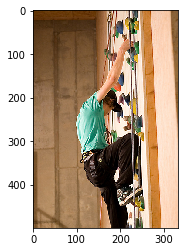

>Generated caption: 
skateboarder does trick on his skateboard
>Original captions: 
man in green shirt climbs an indoor climbing wall
man in green shirt is climbing an obstacle course
teenage boy climbs an indoor climbing wall
teenager climbs rock wall
someone climbs an indoor climbing wall
>BLEU4 score: 0.000


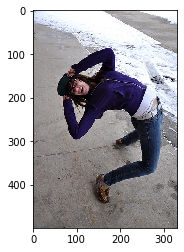

>Generated caption: 
young boy climbing rock wall
>Original captions: 
girl in purple sweatshirt bends over backwards
girl bending backwards holding her hat
person bending backwards
person in blue sweatshirt is doing back bend
woman in blue bends over backwards on the street
>BLEU4 score: 0.000


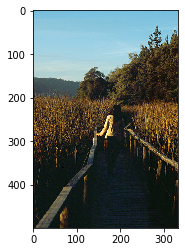

>Generated caption: 
two children are playing in fountain in the woods
>Original captions: 
woman is walking away on wooden walkway through field of golden plants
woman walking over bridge with tall grass on either side of her
woman walks along boardwalk
woman with dark hair walks through grassy field on path with wooden handrails
young woman crosses bridge through field of tall grass
>BLEU4 score: 0.000


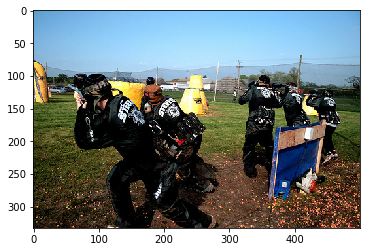

>Generated caption: 
two men on motorcycles down hill
>Original captions: 
bunch of guys in black play paintball
group of people wearing body armour while fighting with paintball guns
paintball team shoots
some people playing paintball
speed ball paintball team starting the first round
>BLEU4 score: 0.000


In [22]:
for e in worst:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


## Beam results

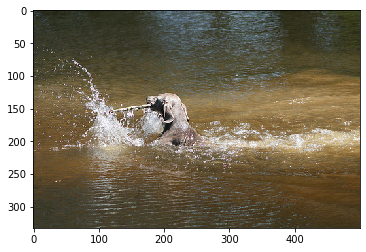

>Generated caption: 
['dog swimming with stick in its mouth', 'dog swimming with stick in his mouth', 'dog swimming in pond', 'dog swimming in water', 'dog swimming with stick in its mouth in the background']
>Original captions: 
dog is fetching stick from lake
dog swimming with stick in its mouth
grey dog swimming through river with stick in his mouth
dog carries stick in mouth while in water
dog swimming through water carrying stick in its mouth
>BLEU4 score: 1.000


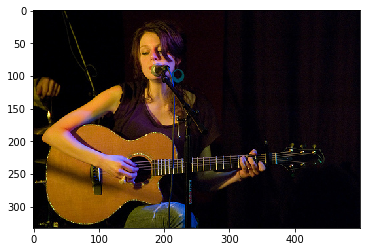

>Generated caption: 
['woman sings into microphone while playing guitar', 'woman sings into microphone by microphone <unk>', 'woman sings into microphone while playing guitar her', 'woman sings into microphone while playing guitar her', 'woman sings into microphone while playing guitar game']
>Original captions: 
woman playing an acoustic guitar with microphone
woman singing and playing the acoustic guitar onstage
woman sings into microphone while playing guitar
young brown haired woman plays her guitar and sings into microphone
young woman plays guitar and sings on stage
>BLEU4 score: 1.000


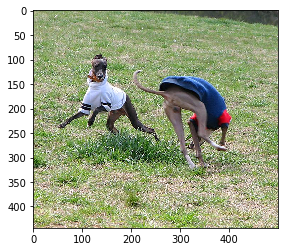

>Generated caption: 
['two dogs play in the grass field', 'two dogs play in the grass field', 'two dogs play in the grass field', 'two dogs play in the grass field ground', 'two dogs play in the grass field ground']
>Original captions: 
the two greyhound dogs wearing sweaters are playing in the grass
two dogs play in the grass
two dogs wearing shirts play in the green grass
two dogs wearing sweaters play in field
two dogs wearing sweaters play in the grass
>BLEU4 score: 0.841


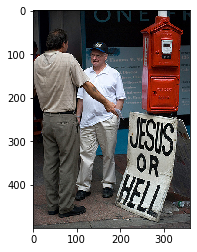

>Generated caption: 
['two men are standing in front of building', 'two men are standing in front of store', 'two men in suits are standing in front of building', 'two men in suits are standing in front of store', 'two men are standing in front of building game']
>Original captions: 
two men are standing beside sign that says jesus or hell
two men are standing in front of protest sign resting on red electric box
two men are talking on the street one is pointing at sign that says jesus or hell beneath red box and the other is standing there listening
two men discuss sign that says jesus or hell
two men talking by red box and poster
>BLEU4 score: 0.841


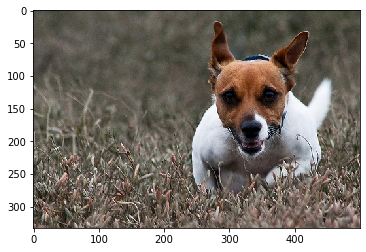

>Generated caption: 
['brown and white dog runs through the grass', 'brown and white dog is running through the grass with stick in its mouth', 'brown and white dog is running through the grass', 'brown and white dog running through the grass', 'brown and white dog is running through the grass in the grass']
>Original captions: 
little white and brown dog runs through brown grass
small dog runs through field
brown and white dog runs through brush
small dog running through field
the dog is running full speed through the meadow
>BLEU4 score: 0.765


In [23]:
results_beam = sorted(results_beam, key=lambda k: k['bleu'], reverse=True) 

top = results_beam[0:5]
worst = results_beam[-5:]

for e in top:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


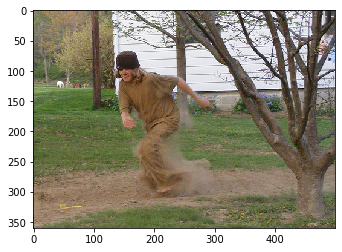

>Generated caption: 
['man throwing stick for dog to fetch', 'man throwing stick for dog to catch ball', 'young boy jumping in the air to catch frisbee', 'man throwing stick for dog to fetch him', 'man throwing stick for dog to fetch him']
>Original captions: 
boy is kicking up dust as he runs in the dirt by tree
boy wearing brown running in dirt
dirty boy runs through the dirt
dusty boy runs along dirt path through the grass
teenage boy runs through the dirt near house in the country
>BLEU4 score: 0.000


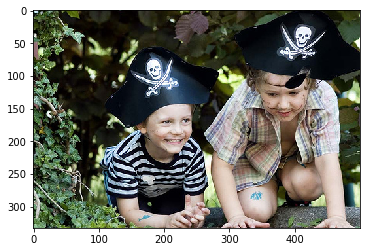

>Generated caption: 
['man and woman pose for picture', 'man and woman are posing for picture', 'man and woman pose for picture them', 'man and woman pose for picture them', 'man and woman pose for picture them']
>Original captions: 
two children are dressed as pirates
two children dressed as pirates
two children kneeling down with pirate hats on
two young boys are kneeling in the bushes wearing pirate costumes
two young boys wearing pirate hats are crouching down
>BLEU4 score: 0.000


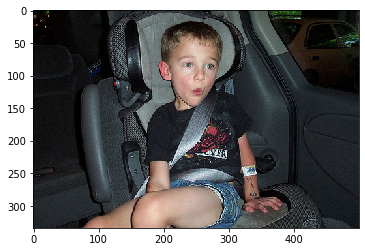

>Generated caption: 
['man and woman sit on park bench', 'man and woman sit on bench in the park', 'man and woman sit on park bench with their arms outstretched', 'man and woman sit on park bench <unk>', 'man and woman sit on park bench <unk>']
>Original captions: 
boy is sitting in car seat in the backseat of car
boy making face while sitting in his car seat
boy sitting in car making surprised face
young boy is buckled into car seat making silly face
the young boy with silly face is buckled in car seat
>BLEU4 score: 0.000


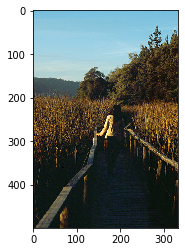

>Generated caption: 
['two children are playing in mud puddle', 'two children are playing on <unk> in the woods', 'two children are playing in mud puddle in the woods', 'two children are playing in fountain', 'two children are playing in fountain in the woods']
>Original captions: 
woman is walking away on wooden walkway through field of golden plants
woman walking over bridge with tall grass on either side of her
woman walks along boardwalk
woman with dark hair walks through grassy field on path with wooden handrails
young woman crosses bridge through field of tall grass
>BLEU4 score: 0.000


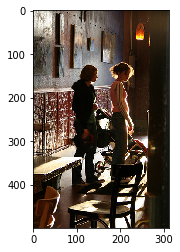

>Generated caption: 
['group of people are riding on <unk> street', 'group of people are standing on railing in front of building', 'group of people are standing on railing in the street', 'group of people are standing on wall in front of building', 'group of people are riding on <unk> street <unk>']
>Original captions: 
two ladies next to stroller inside building
two woman stand near stroller in dark building
two women with baby carriage in building next to table and chairs
two women with baby stroller in fancy restaurant
two women with strollers standing next to table and chair
>BLEU4 score: 0.000


In [24]:
for e in worst:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


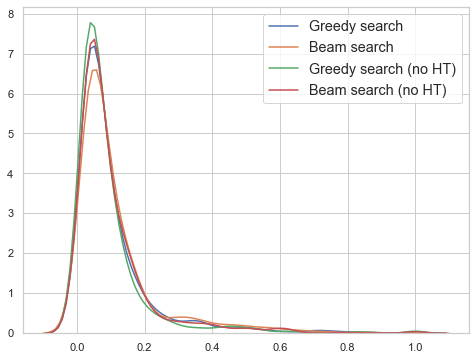

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt

greedy_test_bleu = [d['bleu'] for d in results]
beam_test_bleu = [d['bleu'] for d in results_beam]

data = loadtxt("./data/experiments/2020-04-20/" + 'greedy_beam.csv', delimiter=',')
greedy_test_bleu_nohp = data[0]
beam_test_bleu_nohp = data[1]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.distplot(greedy_test_bleu, label="Greedy search", hist=False)
sns.distplot(beam_test_bleu, label="Beam search", hist=False)
sns.distplot(greedy_test_bleu_nohp, label="Greedy search (no HT)", hist=False)
sns.distplot(beam_test_bleu_nohp, label="Beam search (no HT)", hist=False)
plt.legend(fontsize="large")

In [ ]:
%script False
from numpy import asarray
from numpy import savetxt
from datetime import date
from train_utils import experiment_folder

today = date.today()
d = today.strftime("%m_%d")

data = asarray([greedy_test_bleu, beam_test_bleu])
savetxt(experiment_folder + 'greedy_beam.csv', data, delimiter=',')

from numpy import loadtxt
data = loadtxt(experiment_folder + 'greedy_beam.csv', delimiter=',')
greedy_test_bleu = data[0]
beam_test_bleu = data[1]